In [26]:
# IMPORTS

from torchvision.datasets import ImageFolder
from torchvision import transforms
from sklearn.svm import SVC
from sklearn.model_selection import RandomizedSearchCV, train_test_split
from sklearn.metrics import ConfusionMatrixDisplay, classification_report
from skl2onnx import to_onnx
from torch import nn
import torch, onnx, io, dill
import numpy as np
import onnxruntime as ort
import matplotlib.pyplot as plt

In [2]:
# CONFIGURATION

INPUT_SHAPE = (128, 128)
NUM_CHANNELS = 3
TEST_SIZE = 0.15
SEED = 42
SESSION_NAME = '3_CE_SVM'
MODEL_NAME = 'ce_svm'

In [3]:
# DATA PREPARATION

transform = transforms.Compose([
    transforms.Resize(INPUT_SHAPE),
    transforms.ToTensor(),
])

dataset = ImageFolder('data/raw', transform=transform)

In [4]:
# DATA SPLIT

ds_idx = list(range(len(dataset)))
train_idx, test_idx = train_test_split(ds_idx, test_size=TEST_SIZE, shuffle=True, stratify=dataset.targets, random_state=SEED)

In [5]:
# LOAD DATA

X_train = torch.stack([dataset[i][0] for i in train_idx])
y_train = [dataset[i][1] for i in train_idx]

X_test = torch.stack([dataset[i][0] for i in test_idx])
y_test = [dataset[i][1] for i in test_idx]

In [6]:
# PREPARE MODEL

torch.manual_seed(SEED)
features = nn.Sequential(
    nn.Conv2d(3, 16, 3, 1, 1), nn.ReLU(),
    nn.MaxPool2d(2, 2),
    
    nn.Conv2d(16, 32, 3, 1, 1), nn.ReLU(),
    nn.MaxPool2d(2, 2),
    
    nn.Conv2d(32, 64, 3, 1, 1), nn.ReLU(),
    nn.MaxPool2d(2, 2),
    
    nn.Conv2d(64, 128, 3, 1, 1), nn.ReLU(),
    nn.MaxPool2d(2, 2),
    
    nn.Conv2d(128, 256, 3, 1, 1), nn.ReLU(),
    nn.MaxPool2d(2, 2),
    
    nn.Flatten(),
)

svc = SVC(probability=True)

In [7]:
# HYPERPARAMETER TUNING

param_dist = {
    'C': np.logspace(-3, 3, 7),
    'gamma': np.logspace(-3, 3, 7)
}

rscv = RandomizedSearchCV(svc, param_dist, cv=10, n_jobs=-1, random_state=SEED, scoring='accuracy', verbose=3)

In [8]:
# GET FEATURES

X_train_features = features(X_train).detach()
X_test_features = features(X_test).detach()

In [30]:
dataset.classes

['AK', 'KAPADOKYA', 'NURLU', 'SIRA']

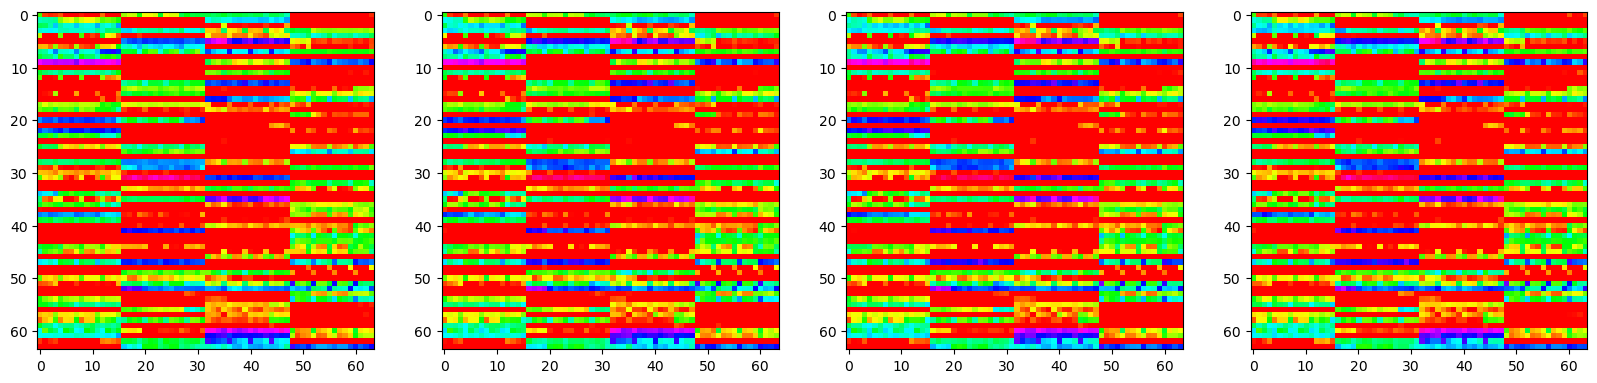

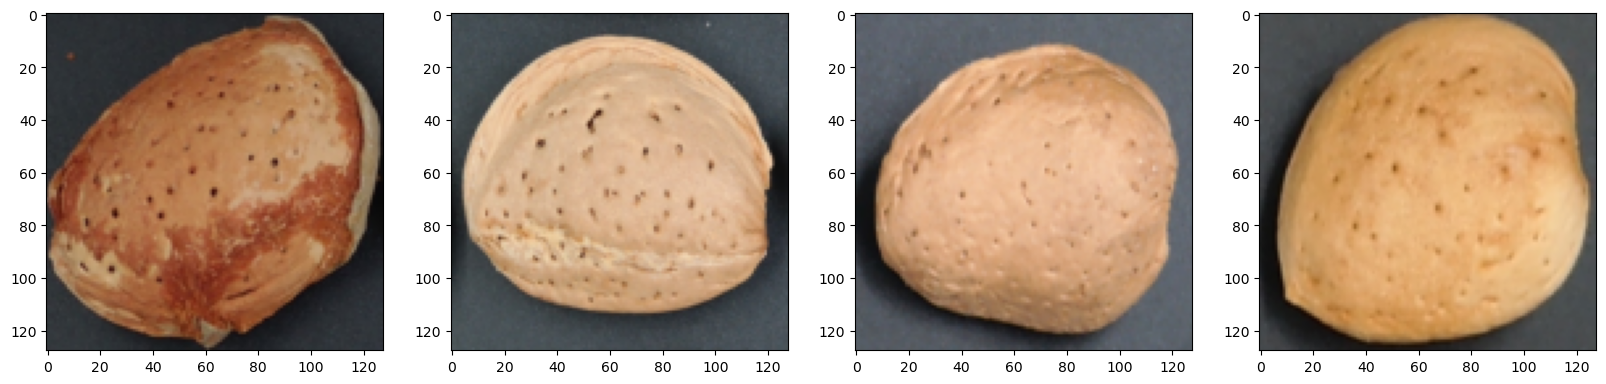

In [37]:
# VISUALIZE FEATURES

plt.figure(figsize=(20, 5))
for i, class_name in enumerate(dataset.classes):
    plt.subplot(1, 4, i+1)
    plt.imshow(X_test_features[y_test.index(i)].reshape(64, 64, 1), cmap='hsv')
    
plt.figure(figsize=(20, 5))
for i, class_name in enumerate(dataset.classes):
    plt.subplot(1, 4, i+1)
    plt.imshow(X_test[y_test.index(i)].permute(1, 2, 0))

In [17]:
# TRAINING

rscv.fit(X_train_features, y_train)

Fitting 10 folds for each of 10 candidates, totalling 100 fits
[CV 5/10] END .............C=0.01, gamma=1000.0;, score=0.295 total time= 1.0min
[CV 3/10] END .............C=0.01, gamma=1000.0;, score=0.295 total time= 1.0min
[CV 6/10] END .............C=0.01, gamma=1000.0;, score=0.295 total time= 1.0min
[CV 7/10] END .............C=0.01, gamma=1000.0;, score=0.303 total time= 1.0min
[CV 2/10] END .............C=0.01, gamma=1000.0;, score=0.293 total time= 1.0min
[CV 4/10] END .............C=0.01, gamma=1000.0;, score=0.295 total time= 1.0min
[CV 8/10] END .............C=0.01, gamma=1000.0;, score=0.303 total time= 1.0min
[CV 1/10] END .............C=0.01, gamma=1000.0;, score=0.301 total time= 1.1min
[CV 5/10] END ..............C=1000.0, gamma=1.0;, score=0.977 total time=  16.3s
[CV 1/10] END ..............C=1000.0, gamma=1.0;, score=0.932 total time=  16.7s
[CV 4/10] END ..............C=1000.0, gamma=1.0;, score=0.992 total time=  16.7s
[CV 3/10] END ..............C=1000.0, gamma=1.

RandomizedSearchCV(cv=10, estimator=SVC(probability=True), n_jobs=-1,
                   param_distributions={'C': array([1.e-03, 1.e-02, 1.e-01, 1.e+00, 1.e+01, 1.e+02, 1.e+03]),
                                        'gamma': array([1.e-03, 1.e-02, 1.e-01, 1.e+00, 1.e+01, 1.e+02, 1.e+03])},
                   random_state=42, scoring='accuracy', verbose=3)

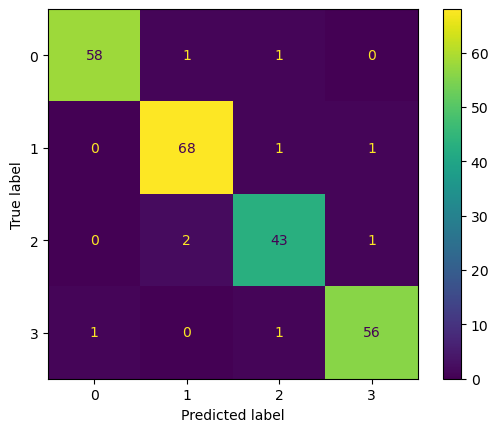

In [18]:
# CONFUSION MATRIX

ConfusionMatrixDisplay.from_estimator(rscv.best_estimator_, X_test_features, y_test)

In [19]:
# CLASSIFICATION REPORT

y_pred = rscv.best_estimator_.predict(X_test_features)
report = classification_report(y_test, y_pred, target_names=dataset.classes)
print(report)

              precision    recall  f1-score   support

          AK       0.98      0.97      0.97        60
   KAPADOKYA       0.96      0.97      0.96        70
       NURLU       0.93      0.93      0.93        46
        SIRA       0.97      0.97      0.97        58

    accuracy                           0.96       234
   macro avg       0.96      0.96      0.96       234
weighted avg       0.96      0.96      0.96       234



In [20]:
# CONVERT TO ONNX

classifier = to_onnx(rscv.best_estimator_, np.array(X_test[:1]).astype(np.float32), options={"zipmap": False})

extractor = io.BytesIO()
torch.onnx.export(
    features, 
    torch.rand(1, 3, INPUT_SHAPE[0], INPUT_SHAPE[1]), 
    extractor, input_names=['input'], output_names=['output'],
    dynamic_axes={'input': {0: '?'}}
)
extractor = onnx.load_model_from_string(extractor.getvalue())

graph = onnx.compose.merge_graphs(extractor.graph, classifier.graph, io_map=[('output', 'X')])
model = onnx.helper.make_model(graph)

In [21]:
# SAVE MODEL

with open(f'models/{MODEL_NAME}.onnx', 'wb') as f:
    f.write(model.SerializeToString())

In [22]:
# SANITY CHECK

sess = ort.InferenceSession(f'models/{MODEL_NAME}.onnx')
output = sess.run(['label', 'probabilities'], {'input': X_test.numpy()})

if (output[0] == y_pred).all():
    print('SUCCESS')
else:
    print('FAILURE')

SUCCESS
